In [1]:
import json
from glob import glob
import os

In [4]:
from tqdm.auto import tqdm
import pandas as pd

In [133]:
new_metrics_agg = pd.read_json('agg_new_metrics.json')

def read_important_metrics(addr):
    with open(addr) as f:
        metrics = json.load(f)
    with open(os.path.join(os.path.split(addr)[0], '../../logdir/checkpoints/_metrics.json')) as f:
        metrics_train = json.load(f)
    if addr in new_metrics_agg.index:
        nm = new_metrics_agg.loc[addr].to_dict()
    else:
        nm = {}        
    
    return {'iou': float(metrics['last']['infer']['mean-iou']), 
            'length': int(metrics_train['best']['_score_'][6:])} | nm

In [3]:
import re
dataset_finder = re.compile(r'_\+experiment=(?P<dataset>.+),attempts=.*,dataset\/gatherers=(?P<interpolation>\w*?),[A-Za-z_,\.=]*?num_volumes=(?P<portion>.*?)\/')


def parse_address(addr):
    res = dataset_finder.search(addr)
    return {'dataset': res.group('dataset'), 
            'interpolation': res.group('interpolation'), 
            'portion': float(res.group('portion'))}

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

In [6]:
names = {'all': ['full', 'biomedisa', 'nearest_5', 'nearest', 'nearest_15', 'sparse', 'sparse_5', 'sparse_15', 'sparse_50', 'sparse_100'], 
         'mix': ['full', 'biomedisa', 'nearest', 'sparse'],
         'nearest': ['full', 'nearest_5', 'nearest', 'nearest_15'], 
         'sparse': ['full', 'sparse_5', 'sparse', 'sparse_15', 'sparse_25', 'sparse_50', 'sparse_100', 'sparse_500'],
         'compare_5': ['full', 'nearest_5', 'sparse_5'],
         'compare_10': ['full', 'nearest', 'sparse'],
         'compare_15': ['full', 'nearest_15', 'sparse_15']}

In [7]:
%%time
experiments = ['2022-04-08_20-03-45', '2022-04-08_20-03-41', '2022-04-12_19-12-56', 
               '2022-04-12_19-23-50', '2022-04-14_18-11-06', 
               '2022-04-15_09-41-33', '2022-04-15_14-13-21', '2022-04-17_12-14-00', '2022-04-17_16-52-55',
               '2022-04-17_20-59-58', '2022-04-17_21-03-22',
               '2022-04-20_13-26-34', '2022-04-20_13-26-52', '2022-04-22_14-33-01',
               '2022-04-22_19-58-37', '2022-04-22_20-10-45',
#                '2022-04-23_17-14-37', 
               '2022-04-23_17-07-12', '2022-04-25_12-33-00',
               '2022-04-25_20-16-10', '2022-04-26_07-35-37']

all_metrics_addrs = []
for exp in experiments:
    all_metrics_addrs += glob(f'/home/ws/tb0536/logs/medaka-supervised/{exp}/*/*/logdir_inference/checkpoints/_metrics.json', recursive=True)

len(all_metrics_addrs)

CPU times: user 365 ms, sys: 201 ms, total: 566 ms
Wall time: 8.24 s


873

In [9]:
parse_address(all_metrics_addrs[0])

{'dataset': 'heart', 'interpolation': 'full', 'portion': 0.6}

In [8]:
from skimage import metrics

In [9]:
import tifffile

In [10]:
a = tifffile.imread('/mnt/data/decathlon/Task02_Heart/train/labels/la_005.tif')
b = tifffile.imread('/mnt/data/decathlon/Task02_Heart/train/labels_nearest_15/la_005.tif')
v = tifffile.imread('/mnt/data/decathlon/Task02_Heart/train/volumes/la_005.tif')

In [11]:
from inference import Segmenter

In [73]:
import yaml

with open('inference_configs/checkpoint/first_attempt.yaml') as f:
    cpcfg = yaml.safe_load(f)

with open('training_configs/model/single_class_decathlon.yaml') as f:
    mdcfg = yaml.safe_load(f)

pccfg = {'batch_size': 64, 'dtype': 'uint8'}

In [74]:
channels_count = {'brain_tumor': 2, 'heart': 2, 'liver': 2, 'medaka_brain': 6, 'xenopus': 2}
def get_seger(chpt_addr):
    new_addr = os.path.join(os.path.split(chpt_addr)[0], 'best.pth')
    return Segmenter(mdcfg | {'classes': channels_count[parse_address(chpt_addr)['dataset']]}, 
                     cpcfg | {'checkpoint_addr': new_addr}, 
                     pccfg)

In [106]:
def get_iou_full(a, b):
    ious = []
    intersection = ((a==1) & (b==1)).sum()
    union = ((a==1) | (b==1)).sum()
    ious.append(intersection/union)
    return np.mean(ious)

In [107]:
def get_dice_full(a, b):
    ious = []
    intersection = 2 * ((a==1) & (b==1)).sum()
    union = (a==1).sum() + (b==1).sum()
    ious.append(intersection/union)
    return np.mean(ious)

In [108]:
def get_new_metrics(l, p):
    l = l[0]
    
    return {'hausdorf': metrics.hausdorff_distance(l, p), 
            'iou_full': get_iou_full(l, p), 
            'dice': get_dice_full(l, p)}

In [44]:
dataset_addrs = {'brain_tumor': '/mnt/data/decathlon/Task01_BrainTumour', 
                 'heart': '/mnt/data/decathlon/Task02_Heart', 
                 'liver': '/mnt/data/decathlon/Task03_Liver', 
                 'medaka_brain': '/mnt/data/decathlon/Task12_Medaka', 
                 'xenopus': '/mnt/data/decathlon/Task11_Xenopus'}

In [70]:
metrics_for_new_metrics_addrs = []
for metric_addr in tqdm(all_metrics_addrs):
    if (parse_address(metric_addr)['interpolation'] in ['full', 'biomedisa', 'nearest_5', 
                                                           'nearest', 'nearest_15']):
        if parse_address(metric_addr)['dataset'] in ['brain_tumor', 'heart', 'liver']:
            metrics_for_new_metrics_addrs.append(metric_addr)
    

  0%|          | 0/873 [00:00<?, ?it/s]

In [101]:
test_data = {}
for dataset_name in tqdm(['brain_tumor', 'heart', 'liver']):
    da = dataset_addrs[dataset_name]
    test_labels = glob(os.path.join(da, 'test', 'labels', '*'))
    test_volumes = [os.path.join(da, 'test', 'volumes', os.path.split(n)[1]) for n in test_labels]
    test_data[dataset_name] = []
    for la, va in tqdm(list(zip(test_labels, test_volumes)), leave=False):
        l = tifffile.imread(la)
        v = tifffile.imread(va)
        test_data[dataset_name].append((l, v))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

In [89]:
from joblib import Parallel, delayed

In [127]:
new_metrics_agg = pd.DataFrame({k: pd.DataFrame(*v).mean() for k,v in new_metrics.items()}).T

In [134]:
all_stats = []
for addr in tqdm(all_metrics_addrs):
    all_stats.append(parse_address(addr) | read_important_metrics(addr))
all_stats = pd.DataFrame(all_stats)

  0%|          | 0/873 [00:00<?, ?it/s]

In [136]:
all_stats

,dataset,interpolation,portion,iou,length,hausdorf,iou_full,dice
0,heart,full,0.6,79.093845,28,41.911098,0.795084,0.884119
1,heart,full,0.4,78.797952,36,14.634706,0.788275,0.880537
2,brain_tumor,biomedisa,0.2,61.763463,15,52.150185,0.595225,0.709529
3,brain_tumor,full,0.6,71.316750,21,47.080007,0.689636,0.794650
4,brain_tumor,full,0.4,68.179586,8,54.316857,0.660815,0.775927
...,...,...,...,...,...,...,...,...
868,medaka_brain,sparse_25,0.6,81.567867,20,NaN,NaN,NaN
869,medaka_brain,sparse_25,0.2,79.888830,17,NaN,NaN,NaN
870,medaka_brain,sparse_25,1.0,81.996249,20,NaN,NaN,NaN
871,medaka_brain,sparse_25,0.8,82.324768,19,NaN,NaN,NaN


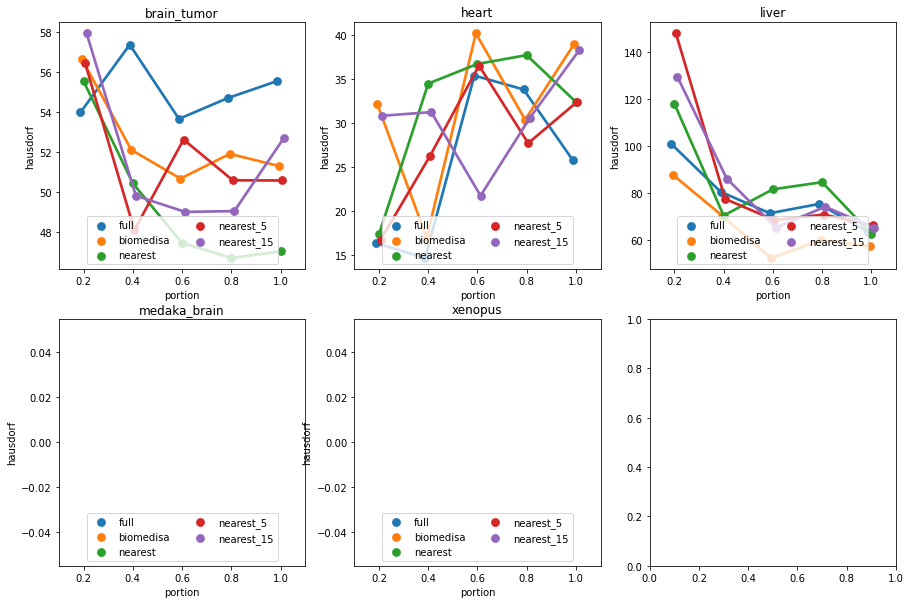

In [147]:
fig, axes = plt.subplots(figsize=(15, 10), ncols=3, nrows=2)
for i, (dataset_name, local_stats) in enumerate(all_stats.groupby('dataset')):
    cax = axes[i//3][i%3]
    sns.pointplot(data=local_stats, x='portion', y='hausdorf', hue='interpolation', 
                  hue_order=['full', 'biomedisa', 'nearest', 'nearest_5', 'nearest_15'],
                  ci=0,
                  dodge=True,
                  estimator=np.median,
                  ax=cax)
    cax.set_title(dataset_name)
    cax.legend(loc=8, ncol=2)
plt.show()

In [1583]:
interpolation_qualities = [{'dataset': 'brain_tumor', 'interpolation': 'biomedisa', 'interpolation-iou': 81.3}, 
                           {'dataset': 'brain_tumor', 'interpolation': 'nearest_5', 'interpolation-iou': 89.5},
                           {'dataset': 'brain_tumor', 'interpolation': 'nearest', 'interpolation-iou': 81.2},
                           {'dataset': 'brain_tumor', 'interpolation': 'nearest_15', 'interpolation-iou': 74.6},
                           {'dataset': 'brain_tumor', 'interpolation': 'full', 'interpolation-iou': 100},
                           {'dataset': 'brain_tumor', 'interpolation': 'sparse', 'interpolation-iou': 0},
                           {'dataset': 'brain_tumor', 'interpolation': 'sparse_5', 'interpolation-iou': 0},
                           {'dataset': 'brain_tumor', 'interpolation': 'sparse_15', 'interpolation-iou': 0},
                           {'dataset': 'heart', 'interpolation': 'biomedisa', 'interpolation-iou': 76.5}, 
                           {'dataset': 'heart', 'interpolation': 'nearest_5', 'interpolation-iou': 91.5},
                           {'dataset': 'heart', 'interpolation': 'nearest', 'interpolation-iou': 84.1},
                           {'dataset': 'heart', 'interpolation': 'nearest_15', 'interpolation-iou': 78.6},
                           {'dataset': 'heart', 'interpolation': 'full', 'interpolation-iou': 100},
                           {'dataset': 'heart', 'interpolation': 'sparse', 'interpolation-iou': 0},
                           {'dataset': 'heart', 'interpolation': 'sparse_5', 'interpolation-iou': 0},
                           {'dataset': 'heart', 'interpolation': 'sparse_15', 'interpolation-iou': 0},
                           {'dataset': 'liver', 'interpolation': 'biomedisa', 'interpolation-iou': 93.4},
                           {'dataset': 'liver', 'interpolation': 'nearest_5', 'interpolation-iou': 95.5},
                           {'dataset': 'liver', 'interpolation': 'nearest', 'interpolation-iou': 90.1},
                           {'dataset': 'liver', 'interpolation': 'nearest_15', 'interpolation-iou': 86.9},
                           {'dataset': 'liver', 'interpolation': 'full', 'interpolation-iou': 100},
                           {'dataset': 'liver', 'interpolation': 'sparse', 'interpolation-iou': 0},
                           {'dataset': 'liver', 'interpolation': 'sparse_5', 'interpolation-iou': 0},
                           {'dataset': 'liver', 'interpolation': 'sparse_15', 'interpolation-iou': 0},
                           {'dataset': 'xenopus', 'interpolation': 'full', 'interpolation-iou': 100},
                           {'dataset': 'xenopus', 'interpolation': 'sparse', 'interpolation-iou': 0},
                           {'dataset': 'xenopus', 'interpolation': 'sparse_5', 'interpolation-iou': 0},
                           {'dataset': 'xenopus', 'interpolation': 'sparse_15', 'interpolation-iou': 0},
                           {'dataset': 'xenopus', 'interpolation': 'sparse_50', 'interpolation-iou': 0},
                           {'dataset': 'xenopus', 'interpolation': 'sparse_100', 'interpolation-iou': 0},
                           {'dataset': 'xenopus', 'interpolation': 'sparse_500', 'interpolation-iou': 0},
                           {'dataset': 'medaka_brain', 'interpolation': 'full', 'interpolation-iou': 100},
                           {'dataset': 'medaka_brain', 'interpolation': 'sparse', 'interpolation-iou': 0},
                           {'dataset': 'medaka_brain', 'interpolation': 'sparse_5', 'interpolation-iou': 0},
                           {'dataset': 'medaka_brain', 'interpolation': 'sparse_15', 'interpolation-iou': 0},
                           {'dataset': 'medaka_brain', 'interpolation': 'sparse_25', 'interpolation-iou': 0},]

In [1821]:
mean_full_iou = all_stats[all_stats.interpolation == 'full'].groupby(['dataset', 'portion']).iou.mean()

In [1822]:
normalized_all_stats = pd.merge(all_stats, mean_full_iou, left_on=('dataset', 'portion'), right_index=True)
normalized_all_stats['normalized_iou'] = normalized_all_stats.iou_x / normalized_all_stats.iou_y

In [1823]:
merged_stats = pd.merge(normalized_all_stats, pd.DataFrame(interpolation_qualities), on=('dataset', 'interpolation'))

In [1824]:
segmented_parts = pd.DataFrame({'interpolation': ['full', 'sparse_5', 'sparse', 'sparse_15', 'sparse_25', 'sparse_50', 'sparse_100', 'sparse_500'], 'segmented_part': [1.0, 0.2, 0.1, 1/16, 1/25, 0.02, 0.01, 0.005]})

In [1825]:
joined_with_segmented_parts = pd.merge(merged_stats, segmented_parts, on='interpolation')

In [1826]:
joined_with_segmented_parts['actual_segmented_part'] = joined_with_segmented_parts['portion'] * joined_with_segmented_parts['segmented_part']

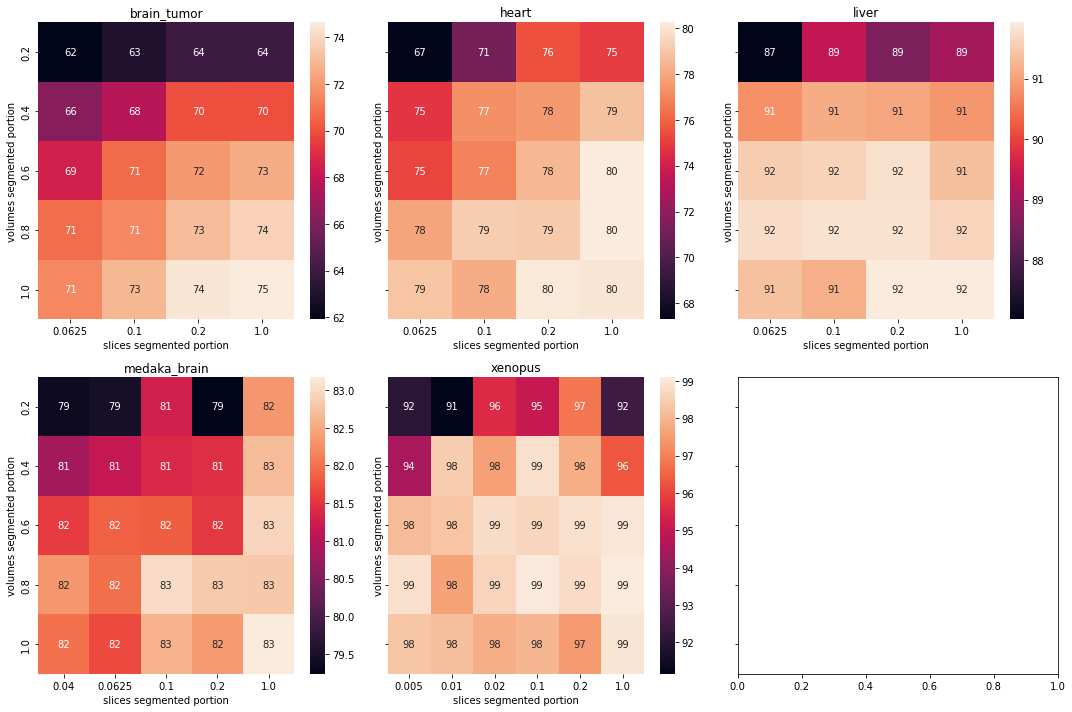

In [1828]:
fig, axes = plt.subplots(figsize=(15, 10), ncols=3, nrows=2, sharey=True)
for i, (dset_name, dset_joined) in enumerate(joined_with_segmented_parts.groupby('dataset')):
    cax = axes[i//3][i%3]
    current_pivot_iou = dset_joined.pivot_table(index='portion', columns='segmented_part', 
                                                values='iou_x', aggfunc='median')
    
    sns.heatmap(current_pivot_iou, annot=True, ax=cax)
    cax.set_title(dset_name)
    cax.set_xlabel('slices segmented portion')
    cax.set_ylabel('volumes segmented portion')
plt.tight_layout()
plt.show()

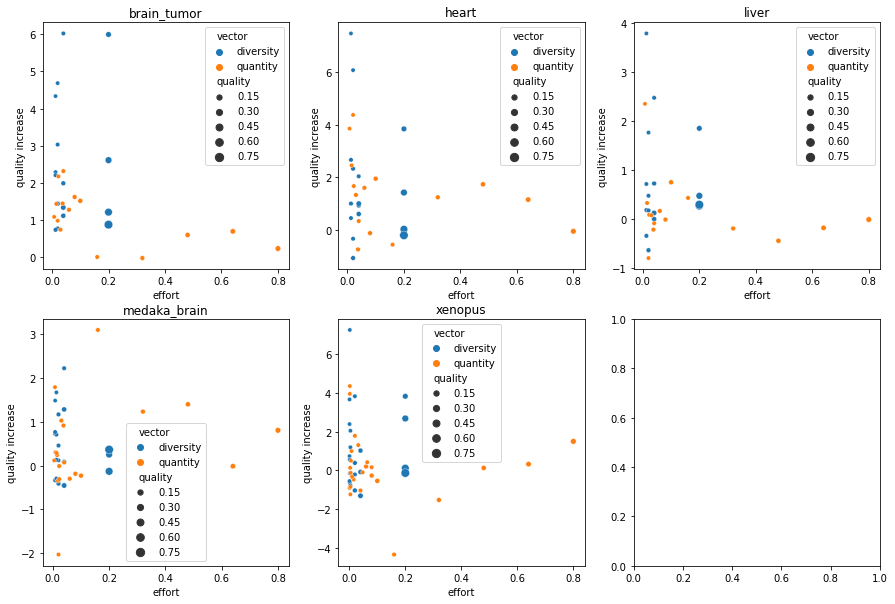

In [1829]:
fig, axes = plt.subplots(figsize=(15, 10), ncols=3, nrows=2)
for i, (dset_name, dset_joined) in enumerate(joined_with_segmented_parts.groupby('dataset')):
    cax = axes[i//3][i%3]
    current_pivot_iou = dset_joined.pivot_table(index='portion', columns='segmented_part', 
                                                values='iou_x', aggfunc='median')
    current_pivot_part = dset_joined.pivot_table(index='portion', columns='segmented_part', 
                                                 values='actual_segmented_part')
    current_increases_diversity = {'effort': (current_pivot_part.values[1:,] - current_pivot_part.values[:-1,]).flatten(),
                                   'quality increase': (current_pivot_iou.values[1:,] - current_pivot_iou.values[:-1,]).flatten(),
                                   'vector': 'diversity',
                                   'quality': current_pivot_part.values[:-1,].flatten().tolist()}
    current_increases_quality = {'effort': (current_pivot_part.values[..., 1:] - current_pivot_part.values[..., :-1]).flatten(),
                                 'quality increase': (current_pivot_iou.values[..., 1:] - current_pivot_iou.values[..., :-1]).flatten(),
                                   'vector': 'quantity',
                                   'quality': current_pivot_part.values[..., :-1].flatten().tolist()}
    cdf = pd.concat([pd.DataFrame(current_increases_diversity), pd.DataFrame(current_increases_quality)])
    
    sns.scatterplot(data=cdf, x='effort', y='quality increase', ax=cax, hue='vector', size='quality')
    cax.set_title(dset_name)

In [1830]:
from scipy.spatial import ConvexHull

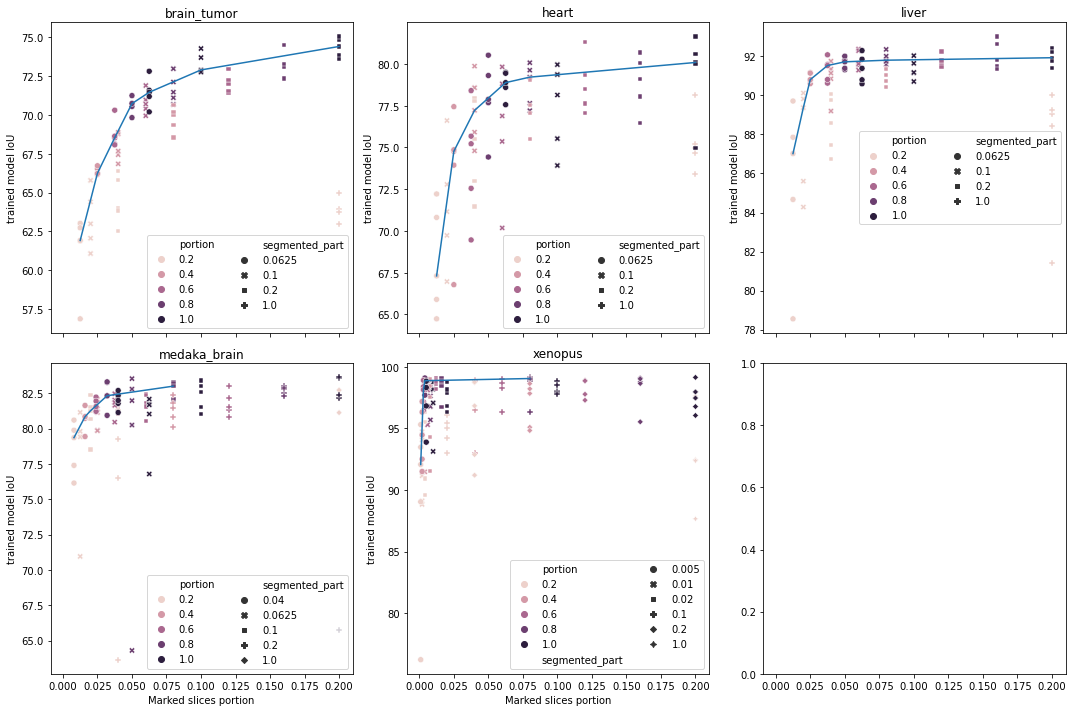

In [1867]:
fig, axes = plt.subplots(figsize=(15, 10), ncols=3, nrows=2, sharex=True)
for i, (dset_name, dset_joined) in enumerate(joined_with_segmented_parts.groupby('dataset')):
    cax = axes[i//3][i%3]
    cds = dset_joined[dset_joined.actual_segmented_part<=0.2]
    sns.scatterplot(data=cds, 
                 x='actual_segmented_part', 
                 y='iou_x', 
                 style='segmented_part', 
                 hue='portion', 
#                  palette=sns.color_palette("viridis", as_cmap=True), 
                    ax=cax)
    ncds = cds.groupby(['interpolation', 'portion']).median().reset_index()
    hull = ConvexHull(ncds[['actual_segmented_part', 'iou_x']])
    cycle_vertices = hull.vertices[::-1].tolist()  + [hull.vertices[-1]]
    locations = []
    for f,t in zip(cycle_vertices[:-1], cycle_vertices[1:]):
        sp = ncds['actual_segmented_part'].iloc[[f, t]].values
        ix = ncds['iou_x'].iloc[[f, t]].values
        if (sp[0] < sp[1]) and (ix[0] < ix [1]):
            locations.append(f)
            locations.append(t)
    locations = list(set(locations))

    sns.lineplot(data=ncds.iloc[locations], 
                     x='actual_segmented_part', 
                     y='iou_x',
                 ax=cax)
    cax.set_xlabel('Marked slices portion')
    cax.set_ylabel('trained model IoU')
    cax.set_title(dset_name)
    cax.legend(ncol=2)
plt.tight_layout()

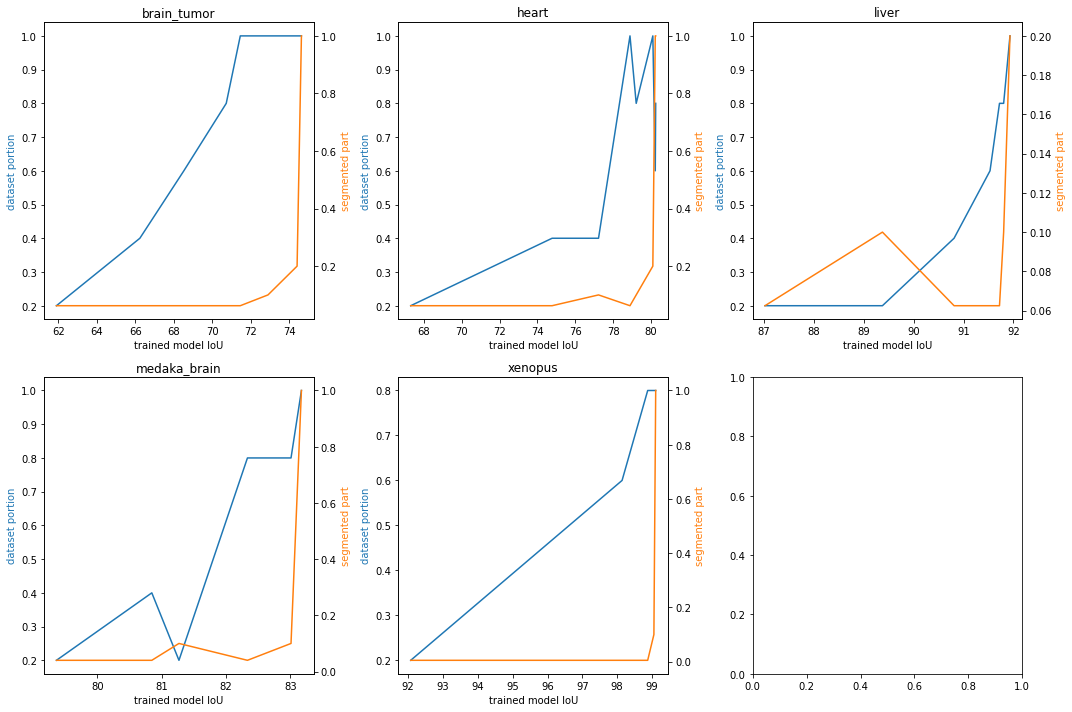

In [1869]:
fig, axes = plt.subplots(figsize=(15, 10), ncols=3, nrows=2)
for i, (dset_name, dset_joined) in enumerate(joined_with_segmented_parts.groupby('dataset')):
    cax = axes[i//3][i%3]
    cds = dset_joined#[dset_joined.actual_segmented_part<=0.2]
    ncds = cds.groupby(['interpolation', 'portion']).median().reset_index()
    hull = ConvexHull(ncds[['actual_segmented_part', 'iou_x']])
    cycle_vertices = hull.vertices[::-1].tolist()  + [hull.vertices[-1]]
    locations = []
    for f,t in zip(cycle_vertices[:-1], cycle_vertices[1:]):
        sp = ncds['actual_segmented_part'].iloc[[f, t]].values
        ix = ncds['iou_x'].iloc[[f, t]].values
        if (sp[0] < sp[1]) and (ix[0] < ix [1]):
            locations.append(f)
            locations.append(t)
    locations = list(set(locations))
    sns.lineplot(data=ncds.iloc[locations], 
                     x='iou_x', 
                     y='portion',
                 ax=cax, color=sns.color_palette()[0])
    caxcopy = cax.twinx()
    sns.lineplot(data=ncds.iloc[locations], 
                     x='iou_x', 
                     y='segmented_part',
                 ax=caxcopy, color=sns.color_palette()[1])

    cax.set_xlabel('trained model IoU')
    cax.set_ylabel('dataset portion', c=sns.color_palette()[0])
    caxcopy.set_ylabel('segmented part', c=sns.color_palette()[1])
    cax.set_title(dset_name)
plt.tight_layout()

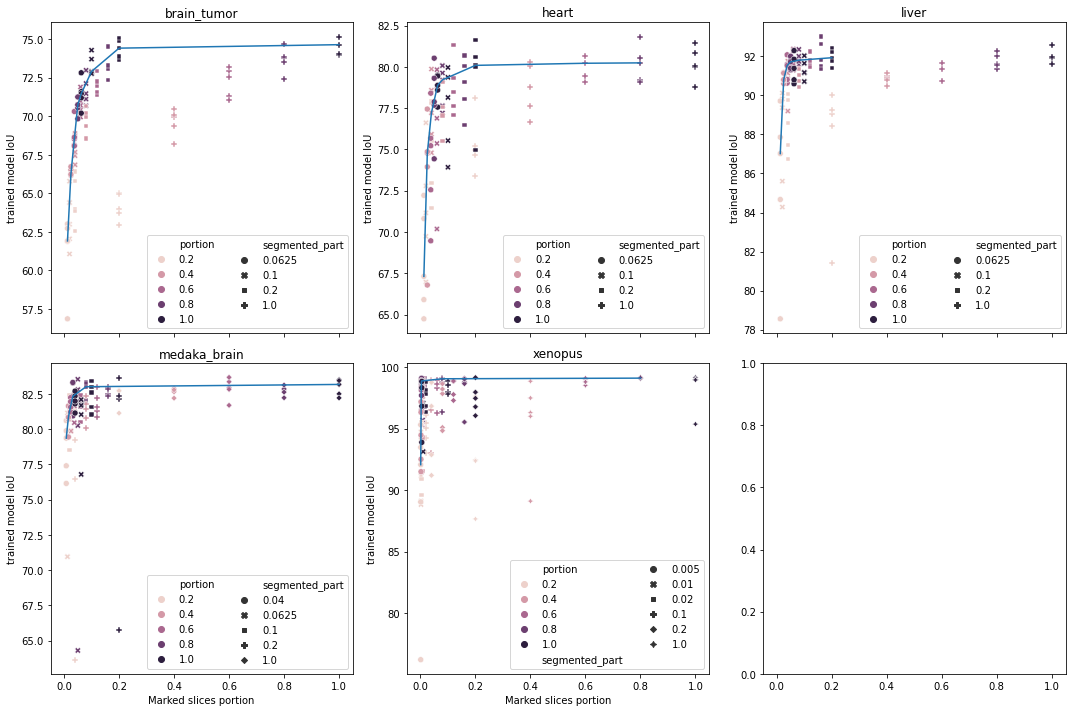

In [1870]:
fig, axes = plt.subplots(figsize=(15, 10), ncols=3, nrows=2, sharex=True)
for i, (dset_name, dset_joined) in enumerate(joined_with_segmented_parts.groupby('dataset')):
    cax = axes[i//3][i%3]
    cds = dset_joined
    ncds = cds.groupby(['interpolation', 'portion']).median().reset_index()
    sns.scatterplot(data=dset_joined, 
                 x='actual_segmented_part', 
                 y='iou_x', 
                 style='segmented_part', 
                 hue='portion', 
#                  palette=sns.color_palette("viridis", as_cmap=True), 
                    ax=cax)
    hull = ConvexHull(ncds[['actual_segmented_part', 'iou_x']])
    cycle_vertices = hull.vertices[::-1].tolist()  + [hull.vertices[-1]]
    locations = []
    for f,t in zip(cycle_vertices[:-1], cycle_vertices[1:]):
        sp = ncds['actual_segmented_part'].iloc[[f, t]].values
        ix = ncds['iou_x'].iloc[[f, t]].values
        if (sp[0] < sp[1]) and (ix[0] < ix [1]):
            locations.append(f)
            locations.append(t)
    locations = list(set(locations))

    sns.lineplot(data=ncds.iloc[locations], 
                     x='actual_segmented_part', 
                     y='iou_x',
                 ax=cax)
    cax.set_xlabel('Marked slices portion')
    cax.set_ylabel('trained model IoU')
    cax.set_title(dset_name)
    cax.legend(ncol=2)
    
plt.tight_layout()

In [1834]:
merged_stats['theoretical_markup_quality'] = merged_stats['portion'] * merged_stats['interpolation-iou']

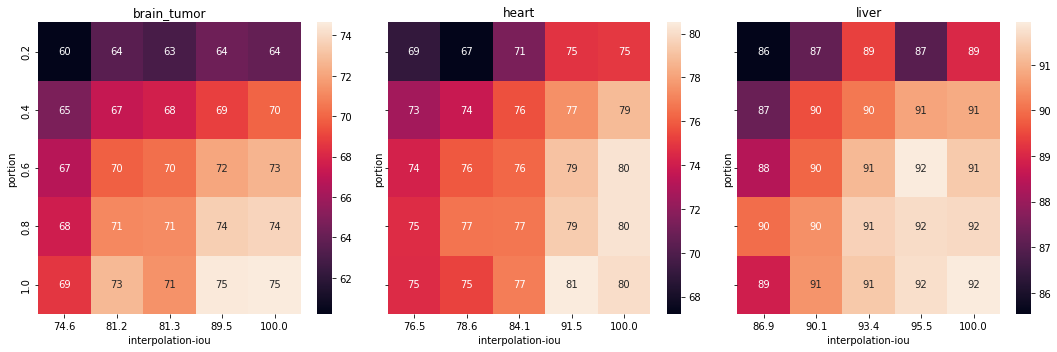

In [1835]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=3, sharey=True)
cms = merged_stats[(merged_stats['interpolation-iou'] > 0) & merged_stats['dataset'].isin(['brain_tumor', 'heart', 'liver'])]
for i, (dset_name, dset_joined) in enumerate(cms.groupby('dataset')):
    current_pivot_iou = dset_joined.pivot_table(index='portion', columns='interpolation-iou', 
                                                values='iou_x', aggfunc='median')
    
    sns.heatmap(current_pivot_iou, annot=True, ax=axes[i])
    axes[i].set_title(dset_name)
plt.tight_layout()
plt.show()

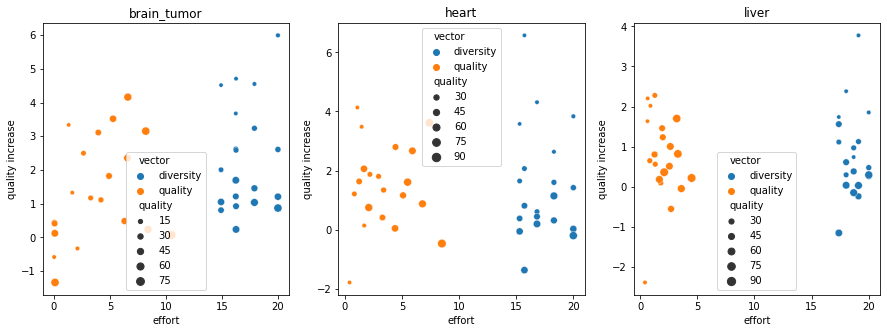

In [1836]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=3)

for i, (dset_name, dset_joined) in enumerate(cms.groupby('dataset')):
    current_pivot_iou = dset_joined.pivot_table(index='portion', columns='interpolation-iou', 
                                                values='iou_x', aggfunc='median')
    current_pivot_part = dset_joined.pivot_table(index='portion', columns='interpolation-iou', 
                                                 values='theoretical_markup_quality')
    current_increases_diversity = {'effort': (current_pivot_part.values[1:,] - current_pivot_part.values[:-1,]).flatten(),
                                   'quality increase': (current_pivot_iou.values[1:,] - current_pivot_iou.values[:-1,]).flatten(),
                                   'vector': 'diversity',
                                   'quality': current_pivot_part.values[:-1,].flatten().tolist()}
    current_increases_quality = {'effort': (current_pivot_part.values[..., 1:] - current_pivot_part.values[..., :-1]).flatten(),
                                 'quality increase': (current_pivot_iou.values[..., 1:] - current_pivot_iou.values[..., :-1]).flatten(),
                                   'vector': 'quality',
                                   'quality': current_pivot_part.values[..., :-1].flatten().tolist()}
    cdf = pd.concat([pd.DataFrame(current_increases_diversity), pd.DataFrame(current_increases_quality)])
    
    sns.scatterplot(data=cdf, x='effort', y='quality increase', ax=axes[i], hue='vector', size='quality')
    axes[i].set_title(dset_name)

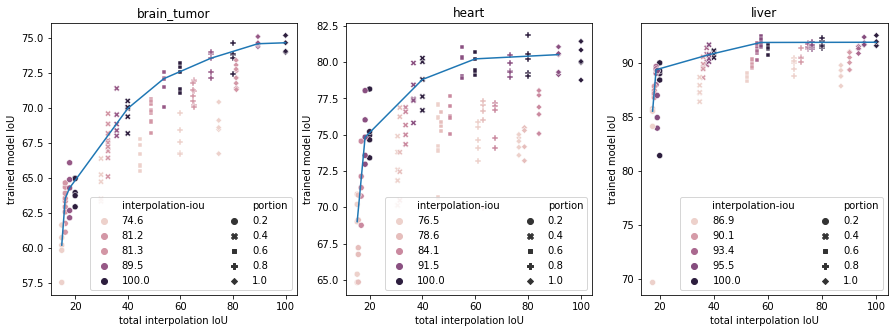

In [1871]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=3)

for i, (dset_name, dset_joined) in enumerate(cms.groupby('dataset')):
    cds = dset_joined
    ncds = cds.groupby(['interpolation', 'portion']).median().reset_index()
    sns.scatterplot(data=dset_joined, 
                    x='theoretical_markup_quality', 
                    y='iou_x', 
                    hue='interpolation-iou', 
                    style='portion',
#                     palette=sns.color_palette("viridis", as_cmap=True),
                    ax=axes[i]
                   )
    hull = ConvexHull(ncds[['theoretical_markup_quality', 'iou_x']])
    cycle_vertices = hull.vertices[::-1].tolist()  + [hull.vertices[-1]]
    locations = []
    for f,t in zip(cycle_vertices[:-1], cycle_vertices[1:]):
        sp = ncds['theoretical_markup_quality'].iloc[[f, t]].values
        ix = ncds['iou_x'].iloc[[f, t]].values
        if (sp[0] < sp[1]) and (ix[0] < ix [1]):
            locations.append(f)
            locations.append(t)
    locations = list(set(locations))

    sns.lineplot(data=ncds.iloc[locations], 
                     x='theoretical_markup_quality', 
                     y='iou_x',
                 ax=axes[i])
    axes[i].set_xlabel('total interpolation IoU')
    axes[i].set_ylabel('trained model IoU')
    axes[i].set_title(dset_name)
    axes[i].legend(ncol=2)

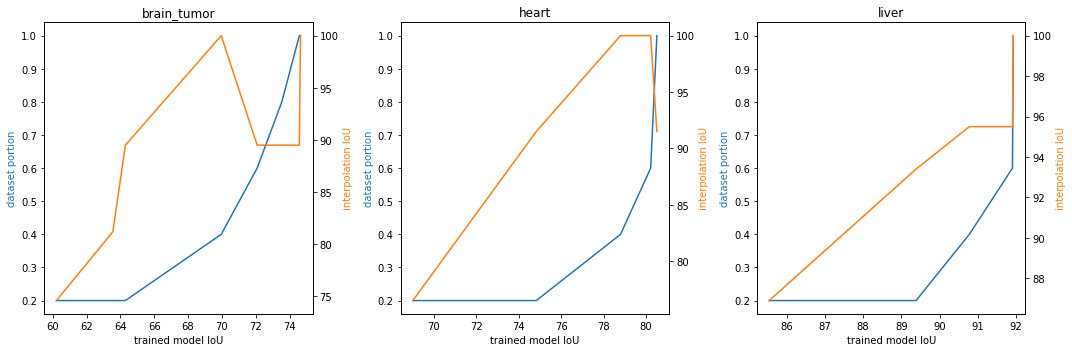

In [1872]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=3)

for i, (dset_name, dset_joined) in enumerate(cms.groupby('dataset')):
    cds = dset_joined
    cax=axes[i]
    ncds = cds.groupby(['interpolation', 'portion']).median().reset_index()
    hull = ConvexHull(ncds[['theoretical_markup_quality', 'iou_x']])
    cycle_vertices = hull.vertices[::-1].tolist()  + [hull.vertices[-1]]
    locations = []
    for f,t in zip(cycle_vertices[:-1], cycle_vertices[1:]):
        sp = ncds['theoretical_markup_quality'].iloc[[f, t]].values
        ix = ncds['iou_x'].iloc[[f, t]].values
        if (sp[0] < sp[1]) and (ix[0] < ix [1]):
            locations.append(f)
            locations.append(t)
    locations = list(set(locations))

    sns.lineplot(data=ncds.iloc[locations], 
                     x='iou_x', 
                     y='portion',
                 ax=cax, color=sns.color_palette()[0])
    caxcopy = cax.twinx()
    sns.lineplot(data=ncds.iloc[locations], 
                     x='iou_x', 
                     y='interpolation-iou',
                 ax=caxcopy, color=sns.color_palette()[1])
    
    cax.set_xlabel('trained model IoU')
    cax.set_ylabel('dataset portion', c=sns.color_palette()[0])
    caxcopy.set_ylabel('interpolation IoU', c=sns.color_palette()[1])
    cax.set_title(dset_name)
#     cax.legend(ncol=2)
plt.tight_layout()

In [ ]:
d = np.abs(np.random.randn(2, 200))/3
d = d[:, (d[0] < 1) & (d[1] < 1)]
d[0] = 1-d[0]

<AxesSubplot:xlabel='effort', ylabel='quality'>

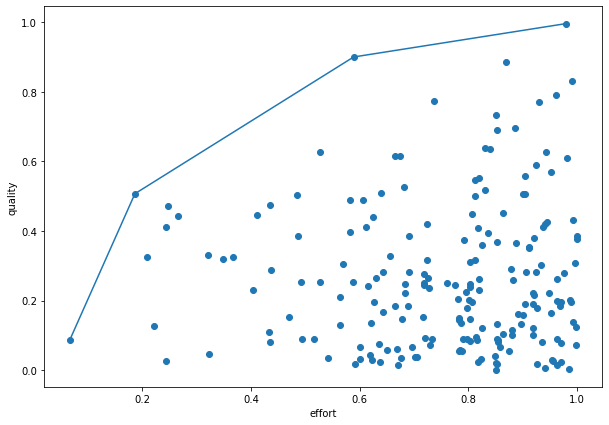

In [1803]:
plt.figure(figsize=(10, 7))
plt.xlabel('effort')
plt.ylabel('quality')
plt.scatter(d[0], d[1])
hull = ConvexHull(d.T)
cycle_vertices = hull.vertices[::-1].tolist()  + [hull.vertices[-1]]
locations = []
for f,t in zip(cycle_vertices[:-1], cycle_vertices[1:]):
    sp = d[0, [f, t]]
    ix = d[1, [f, t]]
    if (sp[0] < sp[1]) and (ix[0] < ix [1]):
        locations.append(f)
        locations.append(t)
locations = list(set(locations))

sns.lineplot(x=d[0, locations], y=d[1, list(set(locations))])

In [1639]:
norm_interpmeans = normalized_all_stats.groupby('interpolation').mean()

In [1640]:
doubled_normalized = pd.merge(normalized_all_stats, normalized_all_stats, on=['dataset'])

In [1641]:
doubled_merged = pd.merge(merged_stats, merged_stats, on=['dataset'])

In [1642]:
def get_difference_in_measures(dataset, first, second):
    selector = (dataset.interpolation_x == first) & (dataset.interpolation_y == second)
    return dataset[selector].normalized_iou_x - dataset[selector].normalized_iou_y

In [1643]:
pairs = [('sparse', 'nearest'), ('sparse', 'biomedisa'), ('sparse', 'full')]

serieses = []

for p in pairs:
    serieses.append(pd.Series(get_difference_in_measures(doubled_normalized, *p), name=str(p)))

<AxesSubplot:xlabel='ways', ylabel='iou_gain'>

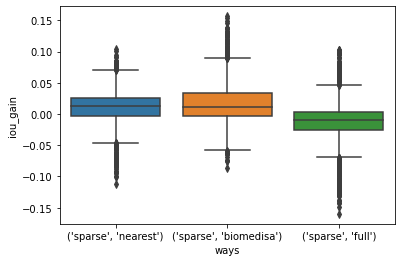

In [1644]:
sns.boxplot(data=pd.DataFrame({'iou_gain': pd.concat(serieses), 'ways': np.concatenate([[s.name]*len(s) for s in serieses])}), x='ways', y='iou_gain')

In [1645]:
comparisons = {'biomedisa': 'sparse',
               'nearest_5': 'sparse_5',
               'nearest': 'sparse',
               'nearest_15': 'sparse_15'}

In [1646]:
serieses = []
for dataset, dataframe in doubled_merged.groupby(['dataset']):
    for p in comparisons.items():
        serieses.append(pd.Series(get_difference_in_measures(dataframe, *p), 
                                  name=dataframe[dataframe.interpolation_x==p[0]]['interpolation-iou_x'].mean()))        

In [1647]:
merged_stats = pd.merge(normalized_all_stats, pd.DataFrame(interpolation_qualities), on=('dataset', 'interpolation'))

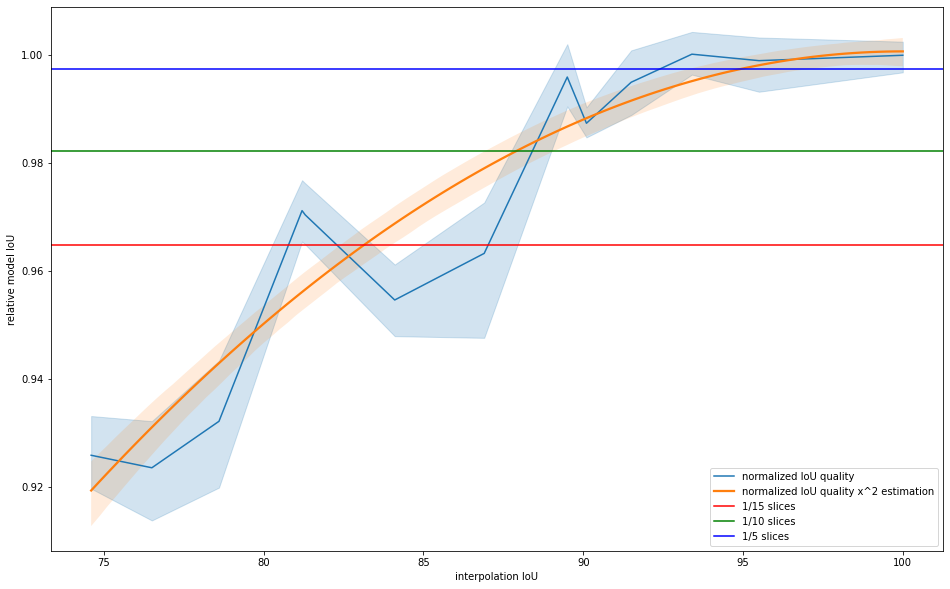

In [1650]:
plt.figure(figsize=(16, 10))
sns.lineplot(data=merged_stats[merged_stats['interpolation-iou']>0], 
             x='interpolation-iou', y='normalized_iou', label='normalized IoU quality')
sns.regplot(data=merged_stats[merged_stats['interpolation-iou']>0], 
            x='interpolation-iou', y='normalized_iou', 
            order=2,
            scatter=False, label='normalized IoU quality x^2 estimation'
           )
plt.axhline(merged_stats[(merged_stats.interpolation == 'sparse_15') & merged_stats.dataset.isin(['brain_tumor', 'heart', 'liver'])]['normalized_iou'].mean(), c='r', label='1/15 slices')
plt.axhline(merged_stats[(merged_stats.interpolation == 'sparse') & merged_stats.dataset.isin(['brain_tumor', 'heart', 'liver'])]['normalized_iou'].mean(), c='g', label='1/10 slices')
plt.axhline(merged_stats[(merged_stats.interpolation == 'sparse_5') & merged_stats.dataset.isin(['brain_tumor', 'heart', 'liver'])]['normalized_iou'].mean(), c='b', label='1/5 slices')
plt.xlabel('interpolation IoU')
plt.ylabel('relative model IoU')
plt.legend()
plt.show()